In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.preprocessing.sequence import pad_sequences

# data prepar

In [2]:
# Load gold historical data from Yahoo Finance
data = yf.download('^XAU', start='2019-01-01', end='2024-01-01') # โหลดข้อมูลมาแล้วระบุวันเริ่มกับวันสุดท้าย

[*********************100%***********************]  1 of 1 completed


In [3]:
data['Return'] = data['Close'].pct_change() # ทำค่าผลต่างเป็นเปอร์เซ็นจากวันปัจจุบันและวันก่อนหน้า return ก็คือผลตอบแทนที่ดได้จากราคาปิดวันนี้เทียบกับเมื่อวาน

# Add more technical indicators
# หา Simple Moving Average ช่วง 10 และ 50 วัน
data['SMA_15'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=15)
data['SMA_30'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=30)
data['SMA_60'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=60)

# หา Relative Strength Index ในช่วง 14 วัน
# หาก RSI ต่ำกว่า 30% จะเรียกว่าภาวะ “ขายมากเกินไป” (Oversold)
# หาก RSI สูงกว่า 70% จะเรียกว่าภาวะ “ซื้อมากเกินไป” (Overbought)
data['RSI'] = ta.RSI(data['Close'].to_numpy().flatten(), timeperiod=14)

# หา Moving Average Convergence Divergence ตัว MACD หาได้จากความต่างของ EMA (Exponential Moving Average) สองเส้นหรือ EMA12 - EMA26
# เอาไว้ดูคู่กับ signal line เพื่อประกอบการตัดสินใจจังหวะซื้อหรือขาย
data['MACD'], data['MACD_Signal'], _ = ta.MACD(data['Close'].to_numpy().flatten(), fastperiod=12, slowperiod=26, signalperiod=9)

# Bollinger Bands กรอบราคาที่สามารเหวี่ยงไปได้ทั้งกรอบบน กรอบล่าง
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['Close'].to_numpy().flatten(), timeperiod=20)

# หา momentum ซึ่งเป็นอัตราเร่งของราคา
data['Momentum'] = ta.MOM(data['Close'].to_numpy().flatten(), timeperiod=10)

# หาความผันผวนของราคาปิดเมื่อเทียบกับราคาสูงสุดและต่ำสุด
data['Volatility'] = ta.ATR(data['High'].to_numpy().flatten(), data['Low'].to_numpy().flatten(), data['Close'].to_numpy().flatten(), timeperiod=14)  # Added Volatility

# หาค่า Stochastic ออกมาเป็นเปอร์เซ็นเพื่อดูพฤติกรรมการซื้อขาย เพื่อหาจุดที่จะเก็งกำไร ส่วนใหญ่ทำในระยะสั้น
data['Stochastic'] = ta.STOCH(data['High'].to_numpy().flatten(), data['Low'].to_numpy().flatten(), data['Close'].to_numpy().flatten(), fastk_period=14, slowk_period=3)[0]  # Added Stochastic

In [4]:
# ทำ label เป็น buy, sell
data['Target'] = np.where(data['Return'].shift(-1) > 0, 1, 0)
data.dropna(inplace=True)
data.head()

Price,Adj Close,Close,High,Low,Open,Volume,Return,SMA_15,SMA_30,SMA_60,RSI,MACD,MACD_Signal,BB_upper,BB_middle,BB_lower,Momentum,Volatility,Stochastic,Target
Ticker,^XAU,^XAU,^XAU,^XAU,^XAU,^XAU,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,
2019-03-28 00:00:00+00:00,76.500000,76.500000,77.629997,75.980003,77.629997,0,-0.025602,76.892000,76.556333,74.479167,50.258699,0.828545,0.725716,79.648093,76.186000,72.723907,1.169998,1.721445,72.853346,0
2019-03-29 00:00:00+00:00,76.360001,76.360001,77.459999,76.320000,77.120003,0,-0.001830,76.914667,76.618333,74.569500,49.728509,0.696150,0.719802,79.621225,76.302000,72.982775,0.309998,1.679913,53.579437,0
2019-04-01 00:00:00+00:00,75.089996,75.089996,76.930000,74.599998,76.620003,0,-0.016632,76.885333,76.600000,74.618167,45.082380,0.483177,0.672477,79.602609,76.326000,73.049391,-0.030006,1.726348,34.451885,1
2019-04-02 00:00:00+00:00,75.279999,75.279999,75.599998,74.889999,75.070000,0,0.002530,76.766000,76.482000,74.675000,45.896798,0.325969,0.603176,79.592978,76.344500,73.096021,-0.120003,1.653752,27.628611,1
2019-04-03 00:00:00+00:00,75.419998,75.419998,75.989998,75.269997,75.589996,0,0.001860,76.632667,76.348667,74.745333,46.526057,0.210253,0.524591,79.395866,76.457999,73.520132,-1.400002,1.587055,22.371325,1


# funtion for split data

In [5]:
def split_data(data, data_range, train_ratio=0.8):
    split_range = int(len(data) * train_ratio)

    features = [
        'Return', 'SMA_15', 'SMA_30', 'SMA_60', 'RSI', 'MACD', 'MACD_Signal',
        'BB_upper', 'BB_middle', 'BB_lower', 'Momentum', 'Volatility', 'Stochastic'
    ]

    pre_x_train = data.iloc[:split_range].loc[:,features]
    pre_y_train = data.iloc[:split_range].loc[:,["Target"]]
    pre_x_test = data.iloc[split_range:].loc[:,features]
    pre_y_test = data.iloc[split_range:].loc[:,["Target"]]

    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for i in range(len(pre_x_train)-data_range):
        # x_tmp = np.transpose(pre_x_train.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_train.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_train.iloc[i+data_range-1].to_numpy()
        x_train.append(x_tmp)
        y_train.append(y_tmp)

    for i in range(len(pre_x_test)-data_range):
        # x_tmp = np.transpose(pre_x_test.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_test.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_test.iloc[i+data_range-1].to_numpy()
        x_test.append(x_tmp)
        y_test.append(y_tmp)

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test

In [6]:
x_train, y_train, x_test, y_test = split_data(data, data_range=30)

(929, 30, 13) (929, 1) (210, 30, 13) (210, 1)


In [7]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(929, 30, 13) (929, 1) (210, 30, 13) (210, 1)


# draf model

In [24]:
def create_cnn1d_gru_model(input_shape, gru_units=64):
    model = models.Sequential()
    
    # CNN Layers (Convolutional Layer + MaxPooling)
    model.add(layers.Conv1D(13, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    
    # model.add(layers.Conv1D(64, 3, activation='relu'))
    # model.add(layers.MaxPooling1D(2))
    
    # model.add(layers.Conv1D(128, 3, activation='relu'))
    # model.add(layers.MaxPooling1D(2))
    
    # Flatten the output from CNN layers to be input to GRU
    model.add(layers.Flatten())
    
    # GRU Layer
    model.add(layers.Reshape((-1, 13)))  # Reshape for GRU, where -1 is sequence length, 128 is feature dimension
    model.add(layers.GRU(gru_units, return_sequences=False))  # GRU Layer
    
    # Fully Connected Layer (Dense Layer)
    model.add(layers.Dense(13, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))  # Output layer (10 classes, change as needed)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4), loss=losses.SparseCategoricalCrossentropy(), 
        # metrics=[metrics.SparseCategoricalAccuracy(), [metrics.TruePositives(), metrics.TrueNegatives(), metrics.FalsePositives(), metrics.FalseNegatives()],
        #          [metrics.Precision(), metrics.Recall(), metrics.F1Score()]]
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    
    return model

my_model = create_cnn1d_gru_model(x_train.shape[1:])

# train

In [25]:
# my_model.summary()
history = my_model.fit(x_train, y_train, batch_size=100, epochs=10)
history.history

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7307 - sparse_categorical_accuracy: 0.4972
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7041 - sparse_categorical_accuracy: 0.5208 
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6910 - sparse_categorical_accuracy: 0.5514
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6879 - sparse_categorical_accuracy: 0.5466
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6868 - sparse_categorical_accuracy: 0.5539 
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6854 - sparse_categorical_accuracy: 0.5490 
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6839 - sparse_categorical_accuracy: 0.5566 
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6870 - sparse_categorical_accuracy: 0.5703 
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6790 - sparse_categorical_accuracy: 0.5754 
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6836 -

{'loss': [0.7203637957572937,
  0.6985519528388977,
  0.6884393095970154,
  0.6851254105567932,
  0.6844901442527771,
  0.6852001547813416,
  0.6841233372688293,
  0.6834116578102112,
  0.6830641627311707,
  0.6830866932868958],
 'sparse_categorical_accuracy': [0.5080732107162476,
  0.5252960324287415,
  0.5543595552444458,
  0.5629709362983704,
  0.5597416758537292,
  0.5522066950798035,
  0.5597416758537292,
  0.5737351775169373,
  0.5640473365783691,
  0.567276656627655]}

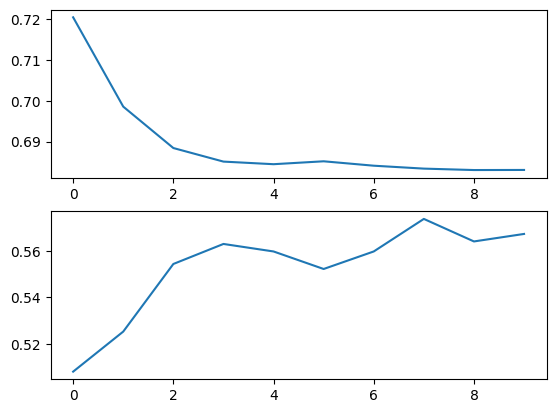

In [26]:
plt.subplot(2, 1, 1)
plt.plot(history.history["loss"])
plt.subplot(2, 1, 2)
plt.plot(history.history["sparse_categorical_accuracy"])
plt.show()

# predict

In [27]:
prediction = my_model.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [45]:
predict_class = np.where(prediction[:,0] < prediction[:,1], 1, 0)
tmp = {"raw_class_0":prediction[:,0], "raw_class_1":prediction[:,1], "predict_class":predict_class, "real_class":y_test.reshape(-1)}
df = pd.DataFrame(tmp)
df.to_csv("test_predict.csv", index=False)

# เพิ่มเติมจาก gpt

gpt ชุด 1

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import backtrader as bt # อันนี้น่าสนใจในการทำ backtest

# Step 1: ดึงข้อมูลจาก Yahoo Finance
data = yf.download('BTC-USD', start='2023-11-20', end='2024-11-20', progress=False)

# Step 2: สร้าง Feature สำหรับ Machine Learning
data['price_roc'] = data['Close'].pct_change() * 100  # Rate of Change ของราคา
data['volume_roc'] = data['Volume'].pct_change() * 100  # Rate of Change ของ volume
data = data.dropna()  # ลบค่า NaN ที่เกิดจากการคำนวณ

# Step 3: กำหนด Target (1 = long, -1 = short)
data['target'] = 0
data.loc[data['price_roc'] > 0, 'target'] = 1  # long หากราคาเพิ่มขึ้น
data.loc[data['price_roc'] < 0, 'target'] = -1  # short หากราคาลดลง

# Step 4: การเตรียมข้อมูลสำหรับการฝึก Machine Learning
X = data[['price_roc', 'volume_roc']]  # Features
y = data['target']  # Target

# แบ่งข้อมูลเป็น train/test (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# สร้างและฝึกโมเดล Machine Learning
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ทำนายผลใน test set
y_pred = model.predict(X_test)

# แสดงผลการทำนาย
print(classification_report(y_test, y_pred))

# Step 5: สร้าง Strategy สำหรับ Backtrader
class MLStrategy(bt.Strategy):
    # กำหนดค่า parameter สำหรับการเข้าสู่ตลาด
    def __init__(self):
        self.model = model
        self.data_close = self.datas[0].close
        self.data_volume = self.datas[0].volume
        self.X = pd.DataFrame({
            'price_roc': self.data_close.pct_change() * 100,
            'volume_roc': self.data_volume.pct_change() * 100
        })
        self.X = self.X.fillna(0)  # แทนที่ NaN ด้วย 0 เพื่อให้ไม่เกิดข้อผิดพลาดในการทำนาย
        self.y_pred = self.model.predict(self.X.values)  # ทำนายคำสั่ง Long/Short
    
    def next(self):
        if self.y_pred[-1] == 1:  # หากทำนาย long
            if not self.position:  # ถ้ายังไม่ได้เปิด position
                self.buy()
        elif self.y_pred[-1] == -1:  # หากทำนาย short
            if not self.position:  # ถ้ายังไม่ได้เปิด position
                self.sell()

# Step 6: การทำ Backtest โดยใช้ Backtrader
cerebro = bt.Cerebro()

# แปลงข้อมูลเป็น backtrader feed
data_bt = bt.feeds.PandasData(dataname=data)

# เพิ่มข้อมูลลงใน cerebro
cerebro.adddata(data_bt)

# เพิ่ม strategy ที่สร้างขึ้น
cerebro.addstrategy(MLStrategy)

# ตั้งค่าขนาดการลงทุนเริ่มต้น
cerebro.broker.set_cash(10000)

# ตั้งค่าค่าคอมมิชชั่น (เช่น 0.1% ต่อการเทรด)
cerebro.broker.set_commission(commission=0.001)

# รัน backtest
cerebro.run()

# แสดงกราฟผลลัพธ์
cerebro.plot()

gpt ชุด 2

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ตัวอย่างการสร้างโมเดล CNN + GRU

# สร้างโมเดล CNN + GRU
def create_cnn_gru_model(input_shape, gru_units=64):
    model = models.Sequential()
    
    # CNN Layers (Convolutional Layer + MaxPooling)
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten the output from CNN layers to be input to GRU
    model.add(layers.Flatten())
    
    # GRU Layer
    model.add(layers.Reshape((-1, 128)))  # Reshape for GRU, where -1 is sequence length, 128 is feature dimension
    model.add(layers.GRU(gru_units, return_sequences=False))  # GRU Layer
    
    # Fully Connected Layer (Dense Layer)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # Output layer (10 classes, change as needed)
    
    return model

# สร้างโมเดล CNN + GRU
input_shape = (64, 64, 3)  # ขนาดของภาพ (64x64 พิกเซล, 3 แชนแนล RGB)
model = create_cnn_gru_model(input_shape)

# คอมไพล์โมเดล
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# แสดงสรุปของโมเดล
model.summary()

# ตัวอย่างการฝึกโมเดล
# สมมุติว่าเรามีข้อมูล train_X และ train_Y เป็นข้อมูลที่ประกอบด้วยลำดับของภาพ
train_X = np.random.rand(100, 10, 64, 64, 3)  # 100 ตัวอย่าง, 10 ภาพในแต่ละลำดับ
train_Y = np.random.randint(0, 10, (100,))  # 100 ป้ายกำกับ (10 คลาส)

# การฝึกโมเดล
model.fit(train_X, train_Y, epochs=10, batch_size=16)
